# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果
> 執行後可以發現, 雖然 explained variance ratio 仍然隨著 components 穩定下降  
> 但是分類預測準確率上升不穩定, 可見 penalty 參數調整為 'l1' 不太適合

In [3]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components':[4, 10, 20, 30, 40, 50, 64], 
    'logistic__alpha':np.logspace(-4, 4, 5)
}    # 注意 : 有些KEY是2個底線

search = GridSearchCV(
    pipe,
    param_grid,
    iid=False,
    cv=5,
    return_train_score=False
)

search.fit(X_digits, y_digits)
print(f'Best parameter (CV score{search.best_score_:0.3f}):')
print(search.best_params_)

Best parameter (CV score0.910):
{'logistic__alpha': 0.01, 'pca__n_components': 30}


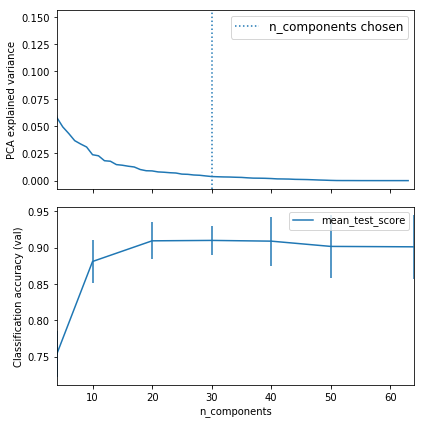

In [4]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

fif, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

ax0.plot(pca.explained_variance_ratio_)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(
    search.best_estimator_.named_steps['pca'].n_components,  # 此值在此範例中為30
    linestyle=':',
    label='n_components chosen'
)
ax0.legend(prop=dict(size=12)) # 顯示每條線的label

# ---------------------------------------------------------------

# 繪製不同採樣點的分類正確率
results = pd.DataFrame(search.cv_results_)
best_clfs = results.groupby('param_pca__n_components').apply(lambda x:x.nlargest(1, 'mean_test_score'))

best_clfs.plot(x='param_pca__n_components', y='mean_test_score', yerr='std_test_score', ax=ax1) 
                                            # yerr : Plotting with Error Bars
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')


plt.tight_layout() # 調整子圖之間的間隔來減少堆疊
plt.show()